In [3]:
import torch
import scipy
import numpy as np
import os
import math
import time
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
from torchsummary import summary
from PIL import Image
import util

In [4]:
#----------------------------------------------------------------------
# the network

class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=24):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.encoder2 = UNet._block(features, features, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.encoder3 = UNet._block(features, features, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.encoder4 = UNet._block(features, features, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.bottleneck = UNet._block(features, features, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features, features, kernel_size=2, stride=1
        )
        self.decoder4 = UNet._block(features*2, features, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features, features, kernel_size=2, stride=1
        )
        self.decoder3 = UNet._block(features*2, features, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features, features, kernel_size=2, stride=1
        )
        self.decoder2 = UNet._block(features*2, features, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features, features, kernel_size=2, stride=1
        )
        self.decoder1 = UNet._block(features*2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return self.conv(dec1)
        # return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


In [35]:
#----------------------------------------------------------------------------
# Dataset noising functions

def fftshift2d(x, ifft=False):
    assert (len(x.shape) == 2) and all([(s % 2 == 1) for s in x.shape])
    s0 = (x.shape[0] // 2) + (0 if ifft else 1)
    s1 = (x.shape[1] // 2) + (0 if ifft else 1)
    x = np.concatenate([x[s0:, :], x[:s0, :]], axis=0)
    x = np.concatenate([x[:, s1:], x[:, :s1]], axis=1)
    return x

bernoulli_mask_cache = dict()
def corrupt_data(img, spec, params):
    ctype = params['type']
    assert ctype == 'bspec'
    p_at_edge = params['p_at_edge']
    global bernoulli_mask_cache
    if bernoulli_mask_cache.get(p_at_edge) is None:
        h = [s // 2 for s in spec.shape]
        r = [np.arange(s, dtype=np.float32) - h for s, h in zip(spec.shape, h)]
        r = [x ** 2 for x in r]
        r = (r[0][:, np.newaxis] + r[1][np.newaxis, :]) ** .5
        m = (p_at_edge ** (1./h[1])) ** r
        bernoulli_mask_cache[p_at_edge] = m
        print('Bernoulli probability at edge = %.5f' % m[h[0], 0])
        print('Average Bernoulli probability = %.5f' % np.mean(m))
    mask = bernoulli_mask_cache[p_at_edge]
    keep = (np.random.uniform(0.0, 1.0, size=spec.shape)**2 < mask)
    keep = keep & keep[::-1, ::-1]
    sval = spec * keep
    smsk = keep.astype(np.float32)
    spec = fftshift2d(sval / (mask + ~keep), ifft=True) # Add 1.0 to not-kept values to prevent div-by-zero.
    img = np.real(np.fft.ifft2(spec)).astype(np.float32)
    return img, sval, smsk

augment_translate_cache = dict()
def augment_data(img, spec, params):
    t = params.get('translate', 0)
    if t > 0:
        global augment_translate_cache
        trans = np.random.randint(-t, t + 1, size=(2,))
        key = (trans[0], trans[1])
        if key not in augment_translate_cache:
            x = np.zeros_like(img)
            x[trans[0], trans[1]] = 1.0
            augment_translate_cache[key] = fftshift2d(np.fft.fft2(x).astype(np.complex64))
        img = np.roll(img, trans, axis=(0, 1))
        spec = spec * augment_translate_cache[key]
    return img, spec



In [64]:
#----------------------------------------------------------------------------
# Dataset loader

def load_dataset(fn, num_images=None, shuffle=False):
    # datadir = submit.get_path_from_template(config_mri.data_dir)
    datadir = '../mri-pkl'
    if fn.lower().endswith('.pkl'):
        abspath = os.path.join(datadir, fn)
        print ('Loading dataset from', abspath)
        img, spec = util.load_pkl(abspath)
    else:
        assert False

    if shuffle:
        perm = np.arange(img.shape[0])
        np.random.shuffle(perm)
        if num_images is not None:
            perm = perm[:num_images]
        img = img[perm]
        spec = spec[perm]

    if num_images is not None:
        img = img[:num_images]
        spec = spec[:num_images]

    # Remove last row/column of the images, we're officially 255x255 now.
    img = img[:, :-1, :-1]

    # Convert to float32.
    assert img.dtype == np.uint8
    img = img.astype(np.float32) / 255.0 - 0.5

    return img, spec

dataset_train, dataset_test = dict(), dict()
train_img, train_spec = load_dataset('ixi_train.pkl')
test_img, test_spec = load_dataset('ixi_valid.pkl')

im_shape = (259,511)
train_X, train_Y = [0]*train_img.shape[0], [0]*train_img.shape[0]
test_X, test_Y = [0]*test_img.shape[0], [0]*test_img.shape[0]

corrupt_params = {
    'type' : 'bspec',
    'p_at_edge' : 0.001
}

for i in range(train_img.shape[0]):
    train_X[i], _, _ = corrupt_data(train_img[i], train_spec[i], corrupt_params)
    train_Y[i], _, _ = corrupt_data(train_img[i], train_spec[i], corrupt_params)
    train_X[i] = train_X[i][:,:-1]
    train_Y[i] = train_Y[i][:,:-1]

for i in range(test_img.shape[0]):
    test_X[i], _, _ = corrupt_data(test_img[i], test_spec[i], corrupt_params)
    test_Y[i], _, _ = corrupt_data(test_img[i], test_spec[i], corrupt_params)
    test_X[i] = test_X[i][:,:-1]
    test_Y[i] = test_Y[i][:,:-1]

train_X, train_Y = np.array(train_X), np.array(train_Y)
test_X, test_Y = np.array(test_X), np.array(test_Y)

print('data loading done')

Loading dataset from ../mri-pkl/ixi_train.pkl
Loading dataset from ../mri-pkl/ixi_valid.pkl
data loading done


In [65]:
print(train_X.shape, test_Y.shape)

(400, 259, 510) (100, 259, 510)


In [82]:
#--------------------------------------------------------------
# Training model

model = UNet(init_features=24)
epochs = 6
batch_size = 4

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

device = torch.device("cuda:3")
torch.cuda.set_device(device)
print(device, torch.cuda.current_device())
model.to(device)


for ep in range(epochs):

    running_loss = 0.0
    i = 0
    while i < len(train_X):

        inputs = train_X[i : i+batch_size]
        inputs = inputs[:, np.newaxis, :, :].astype(np.float32)
        inputs = torch.from_numpy(inputs)
        labels = train_Y[i : i+batch_size]
        labels = labels[:, np.newaxis, :, :].astype(np.float32)
        labels = torch.from_numpy(labels)

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*len(inputs)
        i += batch_size
        # print("ep %s batch %s loss %.3f" % (ep, i//batch_size, running_loss/i))

    running_loss = running_loss / len(train_X)
    
    print("epoch %s loss = %.3f" % (ep, running_loss))

print('Finished training')

cuda:3 3
epoch 0 loss = 0.034
epoch 1 loss = 0.015
epoch 2 loss = 0.015
epoch 3 loss = 0.015
epoch 4 loss = 0.015
epoch 5 loss = 0.015
Finished training


In [83]:
#------------------------------------------------------
# average psnr

psnr_inp, psnr_out = 0.0, 0.0
for i in range(len(train_X)):
    input = train_X[i][np.newaxis, np.newaxis, :, :].astype(np.float32)
    input = torch.from_numpy(input).to(device)
    output = model(input).cpu().detach().numpy()[0,0]
    input = input.cpu().detach().numpy()[0,0]
    mse_inp = np.square(input - train_img[i]).mean()
    mse_out = np.square(output - train_img[i]).mean()
    psnr_inp -= 10*np.log10(mse_inp)
    psnr_out -= 10*np.log10(mse_out)
psnr_inp /= len(train_X)
psnr_out /= len(train_X)

print("Train data")
print('PSNR of input images: %.2f' % psnr_inp)
print('PSNR of output images: %.2f' % psnr_out)


psnr_inp, psnr_out = 0.0, 0.0
for i in range(len(test_X)):
    input = test_X[i][np.newaxis, np.newaxis, :, :].astype(np.float32)
    input = torch.from_numpy(input).to(device)
    output = model(input).cpu().detach().numpy()[0,0]
    input = input.cpu().detach().numpy()[0,0]
    mse_inp = np.square(input - test_img[i]).mean()
    mse_out = np.square(output - test_img[i]).mean()
    psnr_inp -= 10*np.log10(mse_inp)
    psnr_out -= 10*np.log10(mse_out)
psnr_inp /= len(test_X)
psnr_out /= len(test_X)

print("Test data")
print('PSNR of input images: %.2f' % psnr_inp)
print('PSNR of output images: %.2f' % psnr_out)

Train data
PSNR of input images: 19.45
PSNR of output images: 26.59
Test data
PSNR of input images: 19.40
PSNR of output images: 27.18


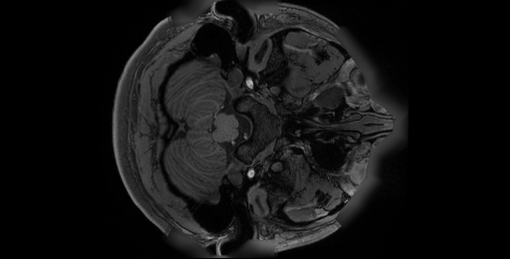

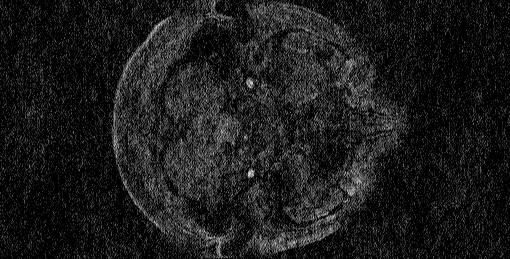

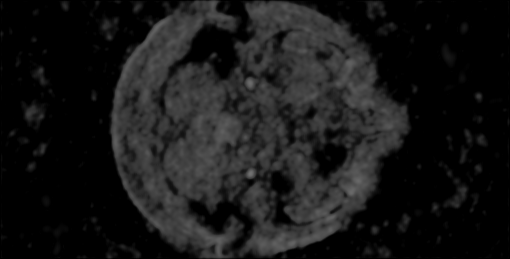

noisy img psnr: 17.66
reconstructed img psnr: 25.67


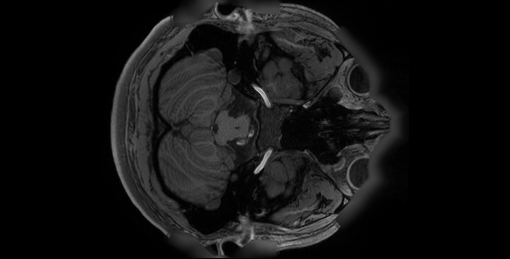

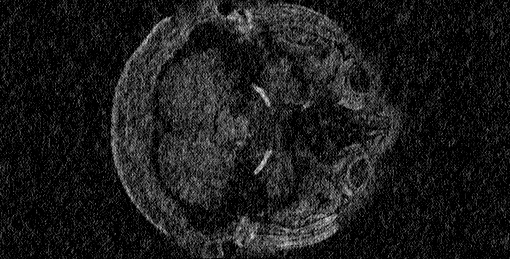

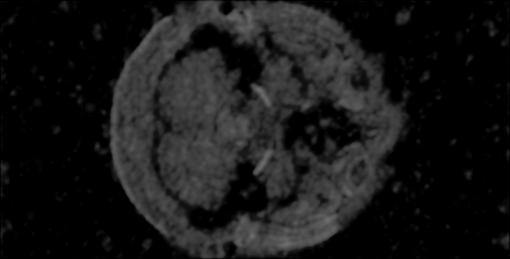

noisy img psnr: 18.20
reconstructed img psnr: 26.25


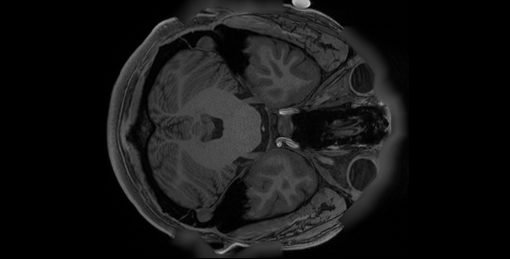

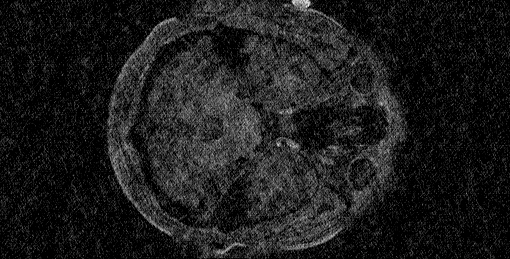

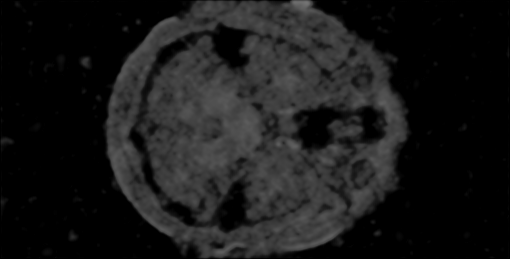

noisy img psnr: 19.28
reconstructed img psnr: 27.24


In [85]:
from IPython.display import display


for id in [2,10,30]:
    img = Image.fromarray((test_img[id]+0.5)*255)
    img = img.convert('L')
    img.save("img/clean_%s.png" % id)
    display(img)

    img = Image.fromarray((test_X[id]+0.5)*255)
    img = img.convert('L')
    display(img)
    img.save("img/noisy_%s.png" % id)

    img_arr = test_X[id][np.newaxis, np.newaxis, :, :].astype(np.float32)
    img_arr = torch.from_numpy(img_arr)
    img_arr = img_arr.to(device)
    img_arr = model(img_arr).cpu().detach().numpy()[0,0]
    img_arr_big = (img_arr + 0.5)*255
    img = Image.fromarray(img_arr_big)
    img = img.convert('L')
    display(img)
    img.save("img/output_%s.png" % id)

    psnr = -10*np.log10(np.square(test_X[id]-test_img[id]).mean())
    print("noisy img psnr: %.2f" % psnr)
    psnr = -10*np.log10(np.square(img_arr-test_img[id]).mean())
    print("reconstructed img psnr: %.2f" % psnr)